<a href="https://colab.research.google.com/github/anaguilarar/MT_elements/blob/main/Multi-Target%20prediction%20for%20element%20concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
## clonning repositories
if not os.path.exists("/content/MT_elements") and not os.getcwd().endswith("/content/MT_elements"):
    !git clone https://github.com/anaguilarar/MT_elements.git
    print("Cloned")
    os.chdir("/content/MT_elements")
    
else:
    print("MT_elements directory already exists")
    os.chdir("/content/MT_elements")



MT_elements directory already exists


In [6]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from element_prediction.models.chain_mlfunctions import *
from element_prediction.utils.data_processing import *
from element_prediction.hsi.sp_functions import SpectralData
from element_prediction.utils.reporters import MT_ElementReporter,regressionReporter
from configuration import Configuration

## Element concentration prediction using multi-target regression

The present repository is intended to document the element concentration prediction using a multi-target regression method based on Regressor Chain.
Although many studies have successfully predicted the element concentration prediction using hyperspectral imaging (HSI), here we presented an alternative that besides using HSI, we also included the inter-target dependency as input features.
To determine the effectiveness of applying multi-target (MT) compared with single-target (ST) regression, we predict the concentration values for 17 elements using both methods, and their prediction accuracy was compared.
This notebook is divided into four sections: 
- Spectral data processing
- Single-target regression
- Multi-target regression
- Results comparison.

#### Spectral data processing

The hyperspectral information was first pre-processed in R, where the data was subjected to an outlier removal process, followed by standardisation.
In this step we read the data saved as a CSV file, where the rows are the observations and the columns are the wavelength values.
Before starting, please modify the conguration.py file, to update the directory paths.

Text(0.5, 1.0, 'First derivative')

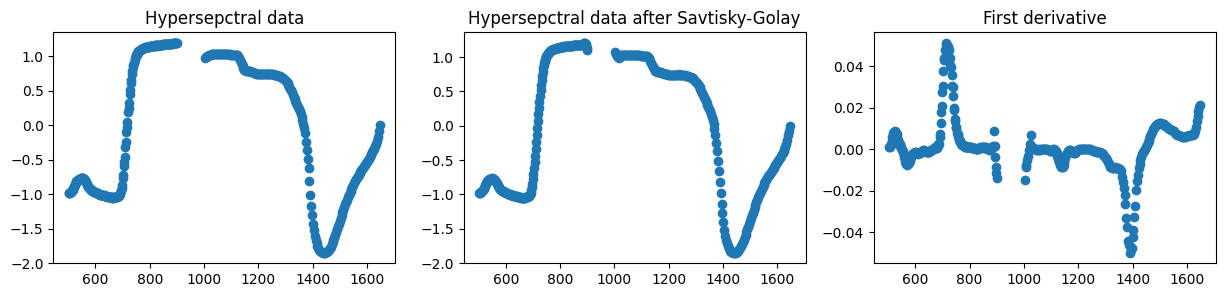

In [ ]:
import matplotlib.pyplot as plt

## folders
sp_path = Configuration.sp_path
nut_values_path = Configuration.target_path


spdata = SpectralData(sp_path, columns_suffix = 'WL.', apply_sg = True)
elementsdata = ElementsData(nut_values_path)

f, ax = plt.subplots(nrows=1, ncols=3, figsize = [15,3])

ax[0].scatter(spdata.wavelengths,spdata.data.iloc[0].values)
ax[0].set_title('Hypersepctral data')
ax[1].scatter(spdata.wavelengths,spdata.data_sg.iloc[0].values)
ax[1].set_title('Hypersepctral data after Savtisky-Golay')
ax[2].scatter(spdata.wavelengths[2:],spdata.first_derivative.iloc[0].values)
ax[2].set_title('First derivative')


### Data splitting

To train and validate the machine learning models, we divided the dataset into two datasets. One for training (90%) and another one for testing (10%). Besides the training dataset is split into 10-folds for cross-validations. The cross-validation results will be used to determine if there is a significance improvement when the models are trained with MT regression.


In [ ]:
idtestvalues = [240, 381, 147,  65, 677, 721,  24, 356, 424, 667, 732,  33, 483,
       669, 330,  29, 413, 559, 663, 716, 548,   8, 443, 671, 655, 363,
       675,  64, 111,   0, 430, 708, 278, 651, 262, 705, 197, 662, 137,
        10,  45, 472, 387, 455, 733, 157, 181, 495, 557, 238, 506, 294,
        61, 513, 544, 415, 234, 360,  13, 372, 643,  90, 600, 193,  16,
       344, 586, 396, 467,  75, 400, 567, 726, 342]


idsfun = SplitIds(spdata.first_derivative.reset_index().shape[0],val_perc =None,
                  seed = 123, shuffle = True, testids_fixed = idtestvalues)


### Single-target and Multi-target regression

Now that we have the element concentration and hyperspectral data, we predict the elements values. To do that we emplyd a function called ElementschainRegressor, which will give first predict a target using single-target moldes the will add individual target prediction until there is not an improvemeent. These results will be used as a reference to determine whether an improvement was achieved.

This is done for each nutrient and regressor model

In [ ]:
streporter  = regressionReporter(_reporter_keys=['id','chain','model','r2', 'rmse', 'prmse', 'mae', 'cv'])


#### Single-target

In [ ]:
conf = Configuration()

for modelname in conf.modelnames:
        st_reporter_output = os.path.join(Configuration.reporterspath,'st_results_{}.json'.format(modelname))
        streporter.reset_reporter()
        for element in conf.elements:
                
                testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                                spdata = spdata.first_derivative.reset_index().drop(['index'], axis = 1),
                                                elements_concentration = ElementsData(nut_values_path),
                                                random_state=42,
                                                ids_order = idsfun)

                ## get cv results
                testrc.cv_sinle_output_fit(element_to_fit=element,kfolds=10)
                pred = testrc.cv_single_output_prediction()
                m = testrc.cv_single_output_validation(pred)

                ## save reporter
                results = {i:list(pd.concat(m)[i].values.astype(float)) 
                        if pd.concat(m)[i].values.dtype == np.int64 
                        else list(pd.concat(m)[i].values) for i in pd.concat(m).columns}
                results.update({'id':element, 'chain':element, 'model':modelname}) 
                streporter.update_reporter(results)

                ## printing
                r2ref = pd.concat(m).r2.mean()
                print('{} {} R squared: {:.3f}'.format(modelname,element, r2ref))
                
        streporter.save_reporter(st_reporter_output)
                

ridge Li R squared: 0.618
ridge B R squared: 0.506
ridge Na R squared: 0.562
ridge Mg R squared: 0.739
ridge P R squared: 0.647
ridge S R squared: 0.580
ridge K R squared: 0.556
ridge Ca43 R squared: 0.699
ridge Mn R squared: 0.674
ridge Fe R squared: 0.529
ridge Co R squared: 0.609
ridge Cu R squared: 0.567
ridge Zn R squared: 0.569
ridge Rb R squared: 0.704
ridge Sr R squared: 0.674
ridge Mo R squared: 0.745
ridge Cd R squared: 0.399
lasso Li R squared: 0.644
lasso B R squared: 0.538
lasso Na R squared: 0.579
lasso Mg R squared: 0.733
lasso P R squared: 0.622
lasso S R squared: 0.538
lasso K R squared: 0.496
lasso Ca43 R squared: 0.632
lasso Mn R squared: 0.667
lasso Fe R squared: 0.522
lasso Co R squared: 0.613
lasso Cu R squared: 0.564
lasso Zn R squared: 0.541
lasso Rb R squared: 0.702
lasso Sr R squared: 0.678
lasso Mo R squared: 0.738
lasso Cd R squared: 0.404
pls Li R squared: 0.612
pls B R squared: 0.484
pls Na R squared: 0.555
pls Mg R squared: 0.708
pls P R squared: 0.611
pl

#### Multi-target

In [ ]:
## reporter: this class will store the prediction results per model
mtreporter  = MT_ElementReporter(_reporter_keys=['id', 'chain', 'r2', 'rmse', 'prmse', 'mae', 'cv'])


In [ ]:

conf = Configuration()

for modelname in ['svr_linear']:
    mt_reporter_output = os.path.join(Configuration.reporterspath,'mt_results_{}.json'.format(modelname))
    if os.path.exists(mt_reporter_output):
        mtreporter.load_reporter(mt_reporter_output)
    else:
        mtreporter.reset_reporter()
        
    mtreporter.fn = mt_reporter_output
    for element_to_predict in conf.elements:

        testrc = ElementsChainRegressor(base_estimator=set_model(modelname, nworkers = -1,scaler ='minmax'),
                                            spdata = spdata.first_derivative.reset_index().drop(['index'], axis = 1),
                                            elements_concentration = ElementsData(nut_values_path),
                                            random_state=42,
                                            ids_order = idsfun)
        
        final_chain, performances = testrc.find_best_chain(element_to_predict,
                                                           kfolds=10, 
                                                           not_include = ['Cd','K', 'B','Fe','Zn'], 
                                                           reporter= mtreporter)

load
initial elements  ['B', 'Ca43', 'Cd', 'Co', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Mo', 'Na', 'P', 'Rb', 'S', 'Sr', 'Zn']
Li: reference accuracy: 0.595
chain Ca43_Li perfomance: 0.595
chain Co_Li perfomance: 0.613
chain Cu_Li perfomance: 0.611
chain Mg_Li perfomance: 0.600
chain Mn_Li perfomance: 0.612
chain Mo_Li perfomance: 0.613
chain Na_Li perfomance: 0.607
chain P_Li perfomance: 0.605
chain Rb_Li perfomance: 0.618
chain S_Li perfomance: 0.607
chain Sr_Li perfomance: 0.602
the chain was updated : Rb_Li
remaining elements  ['Ca43', 'Co', 'Cu', 'Mg', 'Mn', 'Mo', 'Na', 'P', 'S', 'Sr']
chain Ca43_Rb_Li perfomance: 0.597
chain Co_Rb_Li perfomance: 0.613
chain Cu_Rb_Li perfomance: 0.612
chain Mg_Rb_Li perfomance: 0.609
chain Mn_Rb_Li perfomance: 0.615
chain Mo_Rb_Li perfomance: 0.617
chain Na_Rb_Li perfomance: 0.611
chain P_Rb_Li perfomance: 0.611
chain S_Rb_Li perfomance: 0.609
chain Sr_Rb_Li perfomance: 0.606
initial elements  ['Ca43', 'Cd', 'Co', 'Cu', 'Fe', 'K', 'Li', 'Mg', 'Mn', 'Mo', '

### Results

In this step we will obtian the single target and multi target regression results from the reporters.

In [ ]:
streporter  = MT_ElementReporter(_reporter_keys=['id','chain','r2', 'rmse', 'prmse', 'mae', 'cv'])
### single target results 
stresultspermodel = []
for modelname in Configuration.modelnames:
    reporter_path = os.path.join(Configuration.reporterspath,'st_results_{}.json'.format(modelname))
    streporter.load_reporter(reporter_path)
    stresultsperelement = []
    for eoi in tqdm.tqdm(Configuration.elements):
        results = pd.DataFrame(streporter.singletarget_results(eoi, acc_score=['r2', 'rmse', 'prmse', 'mae', 'cv']))
        results =pd.DataFrame(results)
        results['chain'] = eoi
        results['element'] = eoi
        stresultsperelement.append(results)
    dfst = pd.concat(stresultsperelement)
    dfst['model'] = modelname
    stresultspermodel.append(dfst)

load


100%|██████████| 17/17 [00:00<00:00, 1545.90it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1416.52it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1545.40it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1214.31it/s]


load


100%|██████████| 17/17 [00:00<00:00, 1416.85it/s]


In [ ]:
## export file
pd.concat(stresultspermodel).to_csv(os.path.join(Configuration.reporterspath, 'st_results.csv'))

In [ ]:
streporter  = MT_ElementReporter(_reporter_keys=['id','chain','r2', 'rmse', 'prmse', 'mae', 'cv'])

### Multi-target target results 
mtresultspermodel = []
for modelname in Configuration.modelnames:
    reporter_path = os.path.join(Configuration.reporterspath,'mt_results_{}.json'.format(modelname))
    mtreporter.load_reporter(reporter_path)
    mtresultsperelement = []
    for eoi in tqdm.tqdm(Configuration.elements):
        # find the best result for a specific element
        chain, results = mtreporter.multitarget_results(element= eoi)
        pdr = pd.DataFrame(results)
        pdr['chain'] = chain
        pdr['element'] = eoi
        mtresultsperelement.append(pdr)
            
    dfmt = pd.concat(mtresultsperelement)
    dfmt['model'] = modelname
    mtresultspermodel.append(dfmt)
    
pd.concat(mtresultspermodel).to_csv(os.path.join(Configuration.reporterspath, 'mt_results.csv'))


load


100%|██████████| 17/17 [02:14<00:00,  7.94s/it]


load


100%|██████████| 17/17 [04:33<00:00, 16.11s/it]


load


100%|██████████| 17/17 [02:36<00:00,  9.20s/it]


load


100%|██████████| 17/17 [05:14<00:00, 18.48s/it]


load


100%|██████████| 17/17 [04:28<00:00, 15.82s/it]


### Element concentration prediction using test dataset

Finally, once we have found which elements had a significant improvement in their accuracy prediction (this step was done in R, please check the code "r_scripts/figures.R"). We train the multi-target and single-target regression using the test dataset.

In [ ]:
from sklearn.metrics import r2_score


In [ ]:
## elements with significance difference: 
eois = ["Mg", "P", "S", "Mn", "Fe", "Co", "Cu", "Sr", "Mo", "Cd"]

stresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'st_results.csv'))
mtresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'mt_results.csv'))

allresults = []
for eoi in eois:

    ## singletarget

    eoidf = stresults.loc[stresults.element == eoi]
    bestmodel_st = eoidf.groupby(['model']).mean('r2').sort_values(by=['r2'], ascending=False).reset_index(
        ).model.values[0]

    ## multitarget
    eoidf = mtresults.loc[mtresults.element == eoi]
    bestmodel_mt = eoidf.groupby(['model']).mean('r2').sort_values(by=['r2'], ascending=False).reset_index().model.values[0]
    chain = eoidf.loc[eoidf.model == bestmodel_mt].chain.values[0]

    ## MlT prediction

    print('Element {} Multi-target: model {} chain {}'.format(eoi, bestmodel_mt, chain))
    testrc = ElementsChainRegressor(base_estimator=set_model(bestmodel_mt, nworkers = -1,scaler ='minmax'),
                                    spdata = spdata.first_derivative.reset_index().drop(['index'], axis = 1),
                                    elements_concentration = ElementsData(nut_values_path),
                                    random_state=42,
                                    ids_order = idsfun)

    ## multi-target prediction
    testrc.fit_chain(chain = chain)

    ## mt results
    elementsdata = testrc.element_concentrations.data_elements(chain.split('_'))
    tra_x, tra_y, val_x, val_y = get_xyvaldata(testrc.features, elementsdata, phase="validation", split_ids = testrc.split_ids)
    y_predmulti = testrc.predict(val_x.to_numpy())[:,len(chain.split('_'))-1]
    multiresults = pd.DataFrame({'real': val_y.values[:,len(chain.split('_'))-1].ravel(),'pred': y_predmulti,'regressortype': 'multi_target' })
    multiresults['chain'] = chain
    multiresults['model'] = bestmodel_mt

    r2mt = r2_score(
        y_true=multiresults.real.values,
        y_pred=multiresults.pred.values)

    ## single-target prediction
    print('Element {} Single-target: model {}'.format(eoi, bestmodel_st, chain))
    sgmodel = set_model(bestmodel_st, nworkers = -1,scaler ='minmax')
    elementsdata = testrc.element_concentrations.data_elements([eoi])

    tra_x, tra_y, val_x, val_y = get_xyvaldata(testrc.features, 
                                            elementsdata, phase="validation", 
                                            split_ids = testrc.split_ids)

    sgmodel.fit(tra_x.to_numpy(), tra_y.to_numpy().ravel())
    y_pred_single = sgmodel.predict(val_x.to_numpy())
    
    singleresults = pd.DataFrame({'real': val_y.values.ravel(),'pred': y_pred_single,'regressortype': 'single_target' })
    singleresults['chain'] = chain.split('_')[-1]
    singleresults['model'] = bestmodel_st


    r2st = r2_score(
        y_true=singleresults.real.values,
        y_pred=singleresults.pred.values)

    print('Element: {}  ST r2 : {:.3f}  MT r2 {:.3f}'.format(eoi,r2st,r2mt))

    output = pd.concat([singleresults,multiresults])

    output['element'] = chain.split('_')[-1]

    allresults.append(output)


Element Mg Multi-target: model rf chain Cu_P_Mg
training: 668 elements Index(['Cu', 'P', 'Mg'], dtype='object')
Element Mg Single-target: model rf
Element: Mg  ST r2 : 0.833  MT r2 0.900
Element P Multi-target: model rf chain S_Rb_Cu_Mo_P
training: 668 elements Index(['S', 'Rb', 'Cu', 'Mo', 'P'], dtype='object')
Element P Single-target: model rf
Element: P  ST r2 : 0.731  MT r2 0.770
Element S Multi-target: model rf chain Co_Mg_Rb_Cu_Mo_S
training: 668 elements Index(['Co', 'Mg', 'Rb', 'Cu', 'Mo', 'S'], dtype='object')
Element S Single-target: model rf
Element: S  ST r2 : 0.643  MT r2 0.667
Element Mn Multi-target: model rf chain Na_Rb_Cu_Co_Mn
training: 668 elements Index(['Na', 'Rb', 'Cu', 'Co', 'Mn'], dtype='object')
Element Mn Single-target: model ridge
Element: Mn  ST r2 : 0.639  MT r2 0.716
Element Fe Multi-target: model rf chain Rb_Cu_Fe
training: 668 elements Index(['Rb', 'Cu', 'Fe'], dtype='object')
Element Fe Single-target: model svr_linear
Element: Fe  ST r2 : 0.596  MT r2 0

In [ ]:
pd.concat(allresults).to_csv(os.path.join(Configuration.reporterspath, 'test_results.csv'))

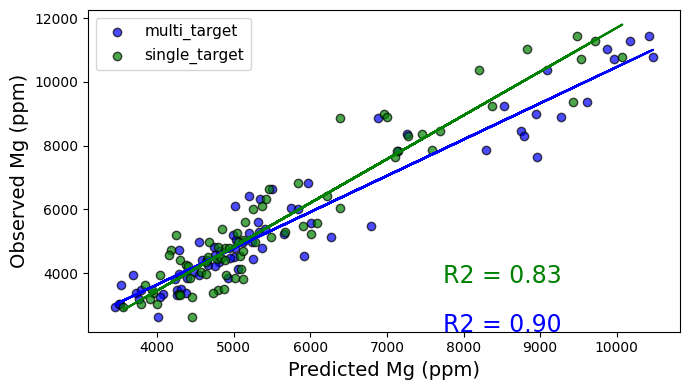

In [ ]:
### plot a single example
dftestresults = pd.read_csv(os.path.join(Configuration.reporterspath, 'test_results.csv'))

fig, ax = plt.subplots(figsize=(7, 4))
eoi = 'Mg'

res = pd.concat(allresults).loc[pd.concat(allresults).element == eoi]
cols = ['blue','green']

for i in range(len(np.unique(res.regressortype.values))):
    regs = np.unique(res.regressortype.values)[i]
    rval = res.loc[res.regressortype == regs]
    m, b = np.polyfit(rval.pred.values.ravel(), rval.real.values.ravel(), 1)
    
    #ax.plot(y_pred_single, val_y.values.ravel(), color='k', label='Regression model')
    ax.scatter(rval.pred.values.ravel(), rval.real.values.ravel(), edgecolor='k', facecolor=cols[i], 
               alpha=0.7, label=regs)
    ax.set_ylabel('Observed {} (ppm)'.format(rval.element.values[0]), fontsize=14)
    ax.set_xlabel('Predicted {} (ppm)'.format(rval.element.values[0]), fontsize=14)
    ax.plot(rval.pred.values.ravel(), m*rval.pred.values.ravel()+b, color=cols[i])
    ax.legend(facecolor='white', fontsize=11)
    r2st = r2_score(
        y_true=rval.real.values,
        y_pred=rval.pred.values)
    
    ax.text(0.6, 0.15*i, 'R2 = %.2f' % (r2st), fontsize=17, transform=ax.transAxes, color = cols[i])

fig.tight_layout()
